In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("new_data_should_work.csv")

In [3]:
df.head(5)

Unnamed: 0  number          date                 range  \
0          18      19  2/11/20 0:48                   htn   
1          19      20  2/11/20 0:50                   HTN   
2          20      21  2/11/20 0:51          hypertension   
3          21      22  2/11/20 0:52          hypertension   
4          22      23  2/11/20 0:53  hypercholesterolemia   

                concept  negation  hof location  correct_answ  hof_answ  \
0  Hypertensive disease         0    1      NaN             1       1.0   
1  Hypertensive disease         0    0      NaN             1       0.0   
2  Hypertensive disease         0    0      NaN             1       1.0   
3  Hypertensive disease         0    0      NaN             1       0.0   
4  Hypertensive disease         0    0      NaN             1       1.0   

   location_answ  negation_answ      bleu  levenshtein  old_cosine_sim  \
0            1.0            1.0  0.263158          0.5         0.67371   
1            1.0            1.0  0.263158          0.5         0.67371   
2            1.0            1.0  0.263158          0.5         0.67371   
3            1.0            1.0  0.263158          0.5         0.67371   
4            1.0            1.0  1.000000          1.0         1.00000   

    jaccard      elmo    cosine  
0  0.500000  0.614541  0.536808  
1  0.500000  0.614594  0.536808  
2  0.533333  0.614598  0.536808  
3  0.533333  0.614598  0.536808  
4  0.928571  0.542407  0.443017

In [4]:
data=df[['correct_answ','levenshtein','jaccard','elmo','cosine']]
# shuffle data
from sklearn.utils import shuffle
data= shuffle(data)

# 1 Data Analysis

In [5]:
data.describe()

correct_answ  levenshtein      jaccard         elmo       cosine
count   1000.000000   1000.00000  1000.000000  1000.000000  1000.000000
mean       0.790000      0.59365     0.618880     0.629648     0.556880
std        0.407512      0.34397     0.265966     0.239366     0.357279
min        0.000000      0.00000     0.000000     0.198427    -0.145935
25%        1.000000      0.25000     0.437500     0.384311     0.286539
50%        1.000000      0.52753     0.636364     0.614598     0.536808
75%        1.000000      0.96000     0.833333     0.901520     1.000000
max        1.000000      1.00000     1.000000     0.949151     1.000000

### 1.1 box-plot of data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129aa6828>,
      dtype=object)

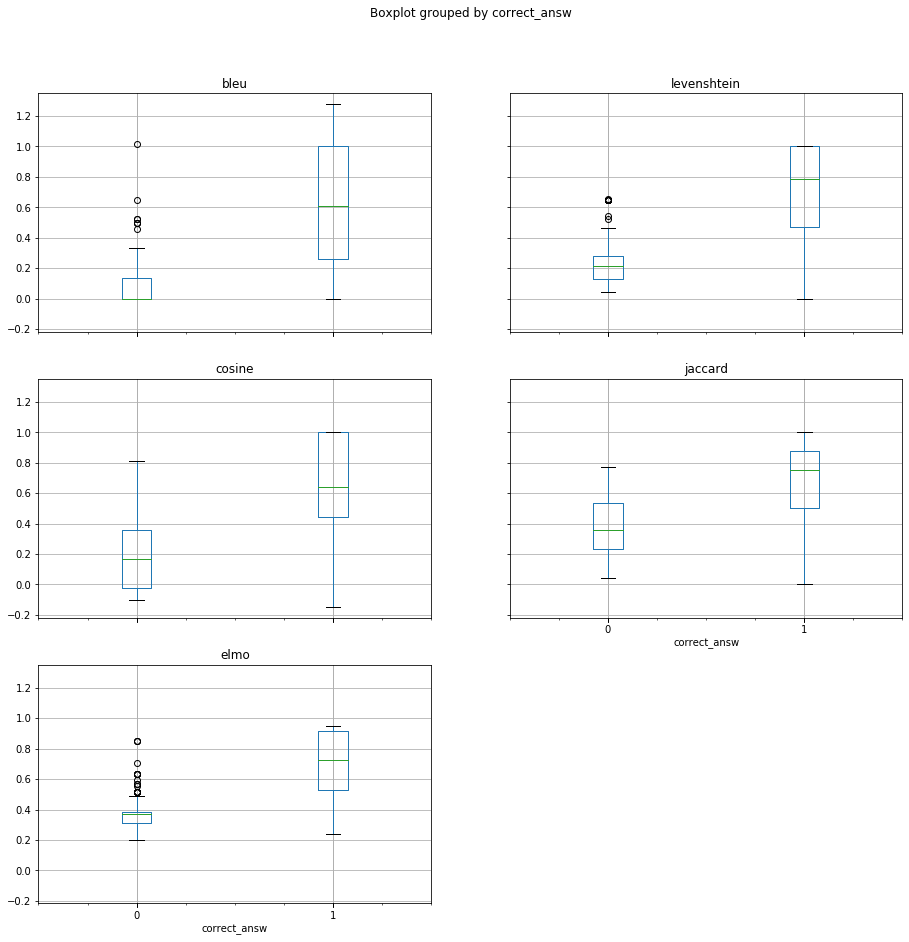

In [6]:
data.boxplot(by = 'correct_answ',column = ['bleu','levenshtein','cosine','jaccard','elmo'],
             grid = True,figsize = (15,15))

In [7]:
X = data[['bleu','levenshtein','cosine','jaccard','elmo']]
y = data['correct_answ']

### 1.2 plot distribution of attributes

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129ad92e8>,
      dtype=object)

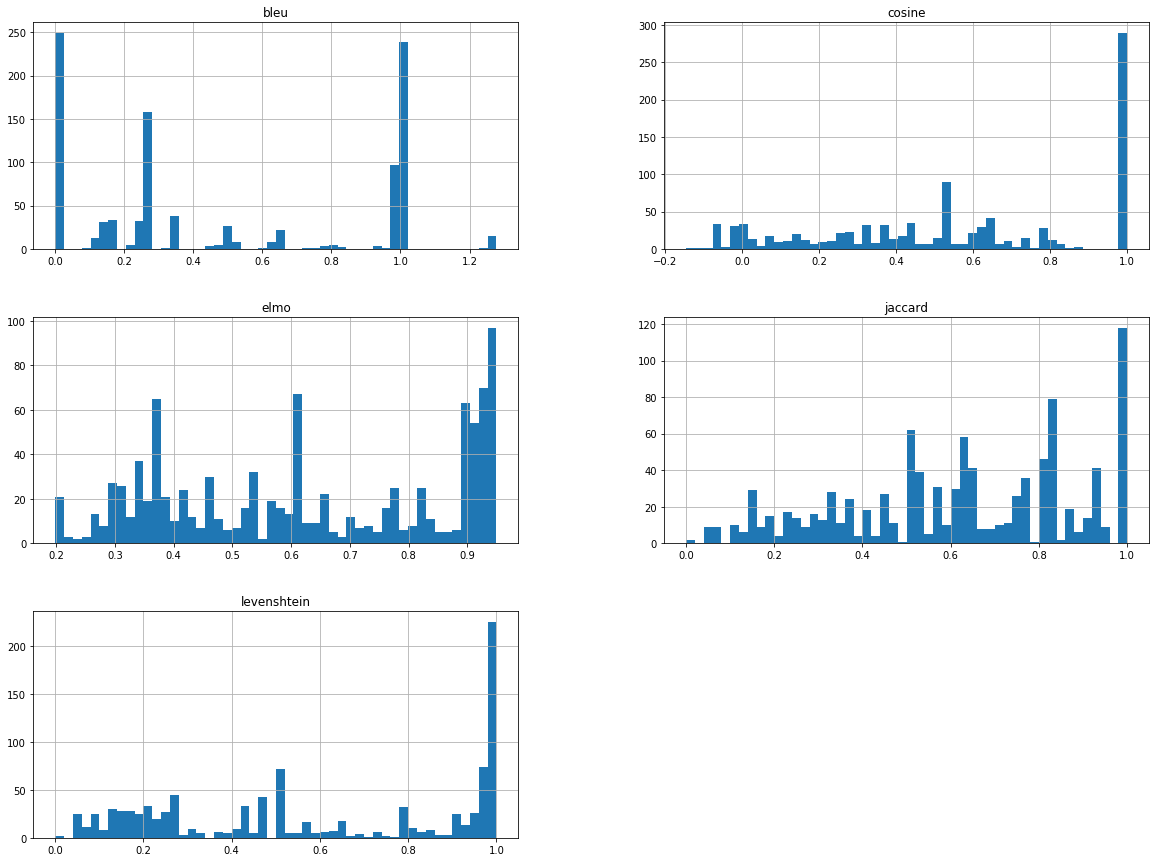

In [8]:
# plot the distributuion of X
X.hist(bins = 50,figsize = (20,15))

### 1.3 plot correlation matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12b7b0c50>,
      dtype=object)

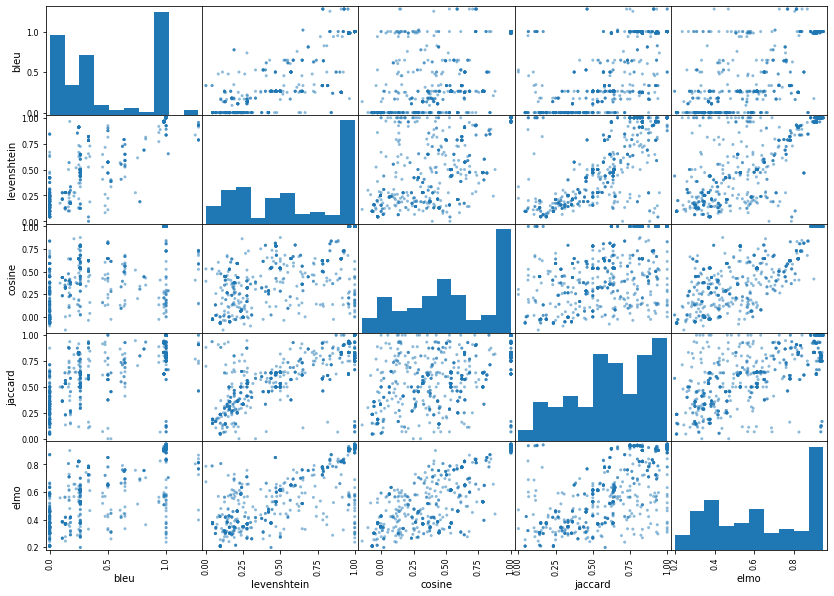

In [9]:
#plot scatter matrix to see the correlation among attributes
from pandas.plotting import scatter_matrix
scatter_matrix(X,figsize = (14,10))

### 1.4 calculate correlation matrix

In [10]:
# calculate correlation matrix to see the relation between each attribute and correnct_answ

corr_matrix = data.corr()
corr_matrix['correct_answ'].sort_values(ascending = False)

correct_answ    1.000000
elmo            0.563272
cosine          0.542933
levenshtein     0.538643
bleu            0.478673
jaccard         0.453930
Name: correct_answ, dtype: float64

# 2 Data preprocess

In [11]:
# stratified split data to make sure training dataset and testing dataset has the same ratio of correct answer and incorrect ones

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in split.split(data, data['correct_answ']):
    strat_training = data.loc[train_index]
    strat_testing = data.loc [test_index]

In [12]:
## counteract problem of unbalanced data

print ("answer value distribution in shuffled data:")
print(data['correct_answ'].value_counts()/len(data))
print(data.shape)
print("----------------------")
print ("answer value distribution in shuffled data:")
print(strat_training['correct_answ'].value_counts()/len(strat_training))
print("----------------------")
print(strat_training.shape)
print ("answer value distribution in shuffled data:")
print(strat_testing['correct_answ'].value_counts()/len(strat_testing))
print(strat_testing.shape)
print("----------------------")

answer value distribution in shuffled data:
1    0.79
0    0.21
Name: correct_answ, dtype: float64
(1000, 6)
----------------------
answer value distribution in shuffled data:
1    0.7825
0    0.2175
Name: correct_answ, dtype: float64
----------------------
(800, 6)
answer value distribution in shuffled data:
1    0.82
0    0.18
Name: correct_answ, dtype: float64
(200, 6)
----------------------


In [13]:
X_training = strat_training[['bleu','levenshtein','jaccard','cosine','elmo']]
X_testing = strat_testing[['bleu','levenshtein','jaccard','cosine','elmo']]
y_training = strat_training[['correct_answ']]
y_testing = strat_testing[['correct_answ']]

# 3 Model training
## 3.1 Logistic Regression
### 3.1.1 k_fold cross validation in training datasets to see performance

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score,confusion_matrix,f1_score
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression

# n_split = 3, in each training, 533 data points will be used for training
# and 266 data points will be used for testing

lr_clf = LogisticRegression(random_state=0)

skfolds = StratifiedKFold(n_splits=3, random_state=42)

precision=[]
recall=[]
f1=[]
for train_index, test_index in skfolds.split(X_training,y_training):
    clone_lr_clf = clone(lr_clf)
    X_train_folds = X_training.iloc[train_index]
    y_train_folds = y_training.iloc[train_index]
    X_test_folds = X_training.iloc[test_index]
    y_test_folds = y_training.iloc[test_index]
    clone_lr_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_lr_clf.predict(X_test_folds)
    print('confusion_matrix:')
    print(confusion_matrix(y_test_folds,y_pred))
    precision.append(precision_score(y_test_folds,y_pred))
    recall.append(recall_score(y_test_folds,y_pred))
    f1.append(f1_score(y_test_folds, y_pred))
print("mean f1:",np.mean(f1))
print("mean recall:",np.mean(recall))
print("mean precision:",np.mean(precision))
                    
    

confusion_matrix:
[[ 31  27]
 [ 10 199]]
confusion_matrix:
[[ 30  28]
 [ 17 192]]
confusion_matrix:
[[ 34  24]
 [ 14 194]]
mean f1: 0.906948515302085
mean recall: 0.9345019016071646
mean precision: 0.881055501019778


/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1

### 3.1.2 use whole training datasets for trainig and validate performance in testing dataset

A regression model that uses L1 regularization technique is called Lasso Regression and model which uses L2 is called Ridge Regression.

Ridge regression adds “squared magnitude” of coefficient as penalty term to the loss function. Here the highlighted part represents L2 regularization element. 

Lasso Regression (Least Absolute Shrinkage and Selection Operator) adds “absolute value of magnitude” of coefficient as penalty term to the loss function.

In [15]:
# use grid search to optimize the parameters, 
from sklearn.model_selection import GridSearchCV
lr_clf = LogisticRegression()

# *penalty: different regularization methods,  *
# *c: Basically smaller C specify stronger regularization.
# *class_weight: if balanced, it basically means replicating the smaller class until you have as many samples as in the larger one, but in an implicit way.

grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25,50,100,500,1000], 'class_weight':['balanced','None']}
grid_lr_clf_acc = GridSearchCV(lr_clf, param_grid = grid_values,scoring = 'f1')
grid_lr_clf_acc.fit(X_training, y_training)

y_pred= grid_lr_clf_acc.predict(X_testing)

print('confusion_matrix: \n',confusion_matrix(y_testing,y_pred))
print('precision_score: ',precision_score(y_testing,y_pred))
print('recall_score: ',recall_score(y_testing,y_pred))
print('f1_socre: ',f1_score(y_testing,y_pred))
print('best_params_:',grid_lr_clf_acc.best_params_)


/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: 

confusion_matrix: 
 [[ 15  21]
 [  6 158]]
precision_score:  0.88268156424581
recall_score:  0.9634146341463414
f1_socre:  0.9212827988338192
best_params_: {'C': 0.09, 'class_weight': 'None', 'penalty': 'l2'}


/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: 

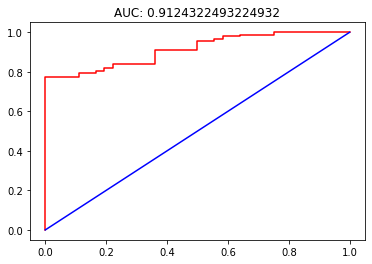

In [17]:
#AUC tells how much model is capable of distinguishing between classes (0,1)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(y_testing,y_pred):
    fpr, tpr, thresholds = roc_curve(y_testing, y_pred[:,1])
    plt.plot(fpr,tpr,'r')
    plt.plot([0,1],[0,1],'b')
    plt.title('AUC: {}'.format(auc(fpr,tpr)))
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()
    
    
plot_roc_auc(y_testing,grid_lr_clf_acc.predict_proba(X_testing))


### 3.1.3 PCA to reduce data dimension to visualize data

use pca to reduce the data dimension to 2-D, then train the 2 new attribute based on the best parameter we get from grid_search. 
As the testing datapoints are predicted based on 5 attribute, and the background point of the figure is predicted based on 2 features, there are some red star in blue background, vice versa. 

/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


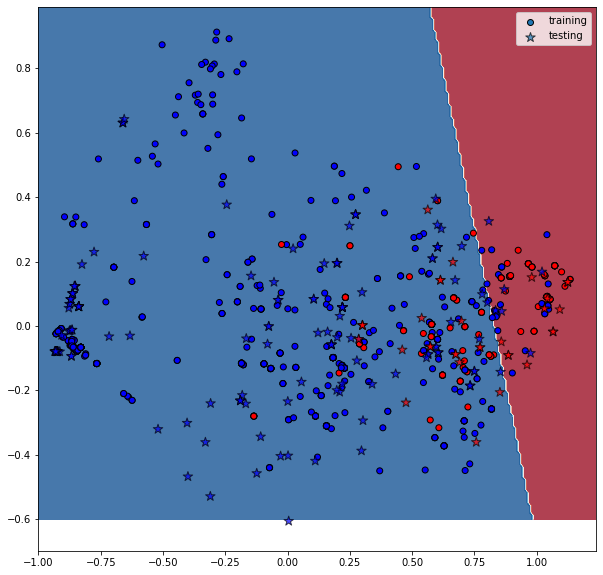

In [26]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap



cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
pca = PCA(n_components=2)
X_training_pca = pca.fit_transform(X_training)
X_testing_pca = pca.fit_transform (X_testing)

lr_clf=clone(grid_lr_clf_acc.best_estimator_)
lr_clf.fit(X_training_pca,y_training)
array1,array2 = np.meshgrid(np.arange(-1,1.25, 0.01),np.arange(-0.6,1, 0.01))
Z = lr_clf.predict(np.c_[array1.ravel(),array2.ravel()])
Z = Z.reshape(array1.shape)


fig=plt.figure(figsize=(10,10))
plt.contourf(array1, array2, Z, cmap=cm, alpha=.8)
plt.scatter(x = X_training_pca[:,0], y = X_training_pca[:,1], c=y_training['correct_answ'],cmap=cm_bright,edgecolors='k',label='training')
plt.scatter(x = X_testing_pca[:,0],y = X_testing_pca[:,1], c=y_testing['correct_answ'], label='testing',marker='*',s=100,cmap=cm_bright, alpha=0.7,edgecolors='k')
plt.legend()


### 3.1.4 calculate the probability for all datapoints for UI

In [27]:
confidence_score = grid_lr_clf_acc.best_estimator_.predict_proba(X)
print(confidence_score)

[[0.02462032 0.97537968]
 [0.52847674 0.47152326]
 [0.02655322 0.97344678]
 ...
 [0.01896238 0.98103762]
 [0.19652749 0.80347251]
 [0.19276633 0.80723367]]


## 3.2 SGD Classifier
### 3.2.1 k_fold cross validation in training datasets to see performance

In [28]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score,confusion_matrix,f1_score
from sklearn.base import clone
from sklearn.linear_model import SGDClassifier

# n_split = 3, in each training, 533 data points will be used for training
# and 266 data points will be used for testing

sgd_clf = SGDClassifier(random_state=0)

skfolds = StratifiedKFold(n_splits=3, random_state=42)

precision=[]
recall=[]
f1=[]
for train_index, test_index in skfolds.split(X_training,y_training):
    clone_sgd_clf = clone(sgd_clf)
    X_train_folds = X_training.iloc[train_index]
    y_train_folds = y_training.iloc[train_index]
    X_test_folds = X_training.iloc[test_index]
    y_test_folds = y_training.iloc[test_index]
    clone_sgd_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_sgd_clf.predict(X_test_folds)
    print('confusion_matrix:')
    print(confusion_matrix(y_test_folds,y_pred))
    precision.append(precision_score(y_test_folds,y_pred))
    recall.append(recall_score(y_test_folds,y_pred))
    f1.append(f1_score(y_test_folds, y_pred))
print("mean f1:",np.mean(f1))
print("mean recall:",np.mean(recall))
print("mean precision:",np.mean(precision))
                    
                    
    

confusion_matrix:
[[ 27  31]
 [  2 207]]
confusion_matrix:
[[ 21  37]
 [  8 201]]
confusion_matrix:
[[ 54   4]
 [ 36 172]]
mean f1: 0.9071122296793438
mean recall: 0.926358728990308
mean precision: 0.8971861471861473


/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1

### 3.2.2 use whole training datasets for trainig and validate performance in testing dataset

A regression model that uses L1 regularization technique is called Lasso Regression and model which uses L2 is called Ridge Regression.

Ridge regression adds “squared magnitude” of coefficient as penalty term to the loss function. Here the highlighted part represents L2 regularization element. 

Lasso Regression (Least Absolute Shrinkage and Selection Operator) adds “absolute value of magnitude” of coefficient as penalty term to the loss function.

In [29]:
# use grid search to optimize the parameters, 
from sklearn.model_selection import GridSearchCV
sgd_clf = SGDClassifier()

# *penalty: different regularization methods,  *
# *c: Basically smaller C specify stronger regularization.
# *class_weight: if balanced, it basically means replicating the smaller class until you have as many samples as in the larger one, but in an implicit way.

grid_values = {'alpha':[0.001,.009,0.01,.09,1,5,10,25,50,100,500,1000],'penalty': ['l1', 'l2'], 'class_weight':['balanced','None'],'loss':['modified_huber','hinge','log']}
grid_sgd_clf_acc = GridSearchCV(sgd_clf, param_grid = grid_values,scoring = 'f1')
grid_sgd_clf_acc.fit(X_training, y_training)

y_pred= grid_sgd_clf_acc.predict(X_testing)

print('confusion_matrix: \n',confusion_matrix(y_testing,y_pred))
print('precision_score: ',precision_score(y_testing,y_pred))
print('recall_score: ',recall_score(y_testing,y_pred))
print('f1_socre: ',f1_score(y_testing,y_pred))
print('best_params_:',grid_sgd_clf_acc.best_params_)

/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expec

confusion_matrix: 
 [[ 36   0]
 [ 40 124]]
precision_score:  1.0
recall_score:  0.7560975609756098
f1_socre:  0.8611111111111112
best_params_: {'alpha': 0.001, 'class_weight': 'balanced', 'loss': 'modified_huber', 'penalty': 'l2'}


/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'None'

  FitFailedWarning)
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Est

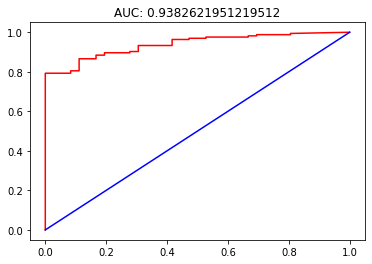

In [30]:
#AUC tells how much model is capable of distinguishing between classes (0,1)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(y_testing,y_pred):
    fpr, tpr, thresholds = roc_curve(y_testing, y_pred[:,1])
    plt.plot(fpr,tpr,'r')
    plt.plot([0,1],[0,1],'b')
    plt.title('AUC: {}'.format(auc(fpr,tpr)))
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()
    
plot_roc_auc(y_testing,grid_sgd_clf_acc.predict_proba(X_testing))

### 3.2.3 PCA to reduce data dimension to visualize data

use pca to reduce the data dimension to 2-D, then train the 2 new attribute based on the best parameter we get from grid_search. 
As the testing datapoints are predicted based on 5 attribute, and the background point of the figure is predicted based on 2 features, there are some red stars in blue background, vice versa. 

/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


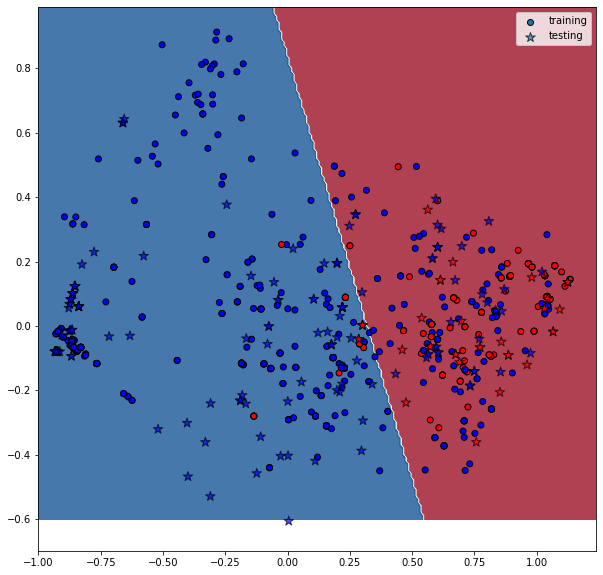

In [31]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap



cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
pca = PCA(n_components=2)
X_training_pca = pca.fit_transform(X_training)
X_testing_pca = pca.fit_transform (X_testing)

sgd_clf=clone(grid_sgd_clf_acc.best_estimator_)
sgd_clf.fit(X_training_pca,y_training)
array1,array2 = np.meshgrid(np.arange(-1,1.25, 0.01),np.arange(-0.6,1, 0.01))
Z = sgd_clf.predict(np.c_[array1.ravel(),array2.ravel()])
Z = Z.reshape(array1.shape)


fig=plt.figure(figsize=(10,10))
plt.contourf(array1, array2, Z, cmap=cm, alpha=.8)
plt.scatter(x = X_training_pca[:,0], y = X_training_pca[:,1], c=y_training['correct_answ'],cmap=cm_bright,edgecolors='k',label='training')
plt.scatter(x = X_testing_pca[:,0],y = X_testing_pca[:,1], c=y_testing['correct_answ'], label='testing',marker='*',s=100,cmap=cm_bright, alpha=0.7,edgecolors='k')
plt.legend()


### 3.2.4 calculate the probability for all datapoints for UI

In [32]:
confidence_score = grid_sgd_clf_acc.best_estimator_.predict_proba(X)
print(confidence_score)

[[0.         1.        ]
 [0.98946679 0.01053321]
 [0.         1.        ]
 ...
 [0.         1.        ]
 [0.26300079 0.73699921]
 [0.43848184 0.56151816]]


## 3.3 knn Classifier
### 3.3.1 k_fold cross validation in training datasets to see performance

In [33]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score,confusion_matrix,f1_score
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier

# n_split = 3, in each training, 533 data points will be used for training
# and 266 data points will be used for testing

knn_clf = KNeighborsClassifier()

skfolds = StratifiedKFold(n_splits=3, random_state=42)


f1=[]
precision=[]
recall=[]
for train_index, test_index in skfolds.split(X_training,y_training):
    clone_knn_clf = clone(knn_clf)
    X_train_folds = X_training.iloc[train_index]
    y_train_folds = y_training.iloc[train_index]
    X_test_folds = X_training.iloc[test_index]
    y_test_folds = y_training.iloc[test_index]
    clone_knn_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_knn_clf.predict(X_test_folds)
    print('confusion_matrix:')
    print(confusion_matrix(y_test_folds,y_pred))
    precision.append(precision_score(y_test_folds,y_pred))
    recall.append(recall_score(y_test_folds,y_pred))
    f1.append(f1_score(y_test_folds, y_pred))
print("mean f1:",np.mean(f1))
print("mean recall:",np.mean(recall))
print("mean precision:",np.mean(precision))
                    
    

confusion_matrix:
[[ 48  10]
 [ 14 195]]
confusion_matrix:
[[ 51   7]
 [ 22 187]]
confusion_matrix:
[[ 50   8]
 [ 11 197]]
mean f1: 0.9413546150418283
mean recall: 0.9249555269292111
mean precision: 0.9587042159081385


/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

### 3.3.2 use whole training datasets for trainig and validate performance in testing dataset

*n_neighbors represents the number of neighbors to use for kneighbors queries

*p in L_p distance
This is the power parameter for the Minkowski metric. When p=1, this is equivalent to using manhattan_distance(l1), and euliddean_distance(l2) for p=2. For arbitrary p, minkowski distance (l_p) is used

In [34]:
# use grid search to optimize the parameters, 
from sklearn.model_selection import GridSearchCV
k_neighbors = list(range(0,51,1))
distances = [1, 2, 3, 4, 5]
knn_clf = KNeighborsClassifier()


grid_values = dict(n_neighbors=k_neighbors,p=distances)
grid_knn_clf_acc = GridSearchCV(knn_clf, param_grid = grid_values,scoring = 'f1')
grid_knn_clf_acc.fit(X_training, y_training)

y_pred= grid_knn_clf_acc.predict(X_testing)

print('confusion_matrix: \n',confusion_matrix(y_testing,y_pred))
print('precision_score: ',precision_score(y_testing,y_pred))
print('recall_score: ',recall_score(y_testing,y_pred))
print('f1_socre: ',f1_score(y_testing,y_pred))
print('best_params_:',grid_knn_clf_acc.best_params_)

/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Expected n_neighbors > 0. Got 0

  FitFailedWarning)
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:53

confusion_matrix: 
 [[ 33   3]
 [  7 157]]
precision_score:  0.98125
recall_score:  0.9573170731707317
f1_socre:  0.9691358024691358
best_params_: {'n_neighbors': 1, 'p': 1}


/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validat

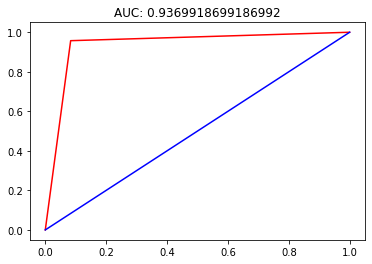

In [35]:
#AUC tells how much model is capable of distinguishing between classes (0,1)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(y_testing,y_pred):
    fpr, tpr, thresholds = roc_curve(y_testing, y_pred[:,1])
    plt.plot(fpr,tpr,'r')
    plt.plot([0,1],[0,1],'b')
    plt.title('AUC: {}'.format(auc(fpr,tpr)))
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()
    
plot_roc_auc(y_testing,grid_knn_clf_acc.predict_proba(X_testing))

### 3.3.3 PCA to reduce data dimension to visualize data

use pca to reduce the data dimension to 2-D, then train the 2 new attribute based on the best parameter we get from grid_search. 
As the testing datapoints are predicted based on 5 attribute, and the background point of the figure is predicted based on 2 features, there are some red stars in blue background, vice versa. 

/Users/chloekim12/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  del sys.path[0]


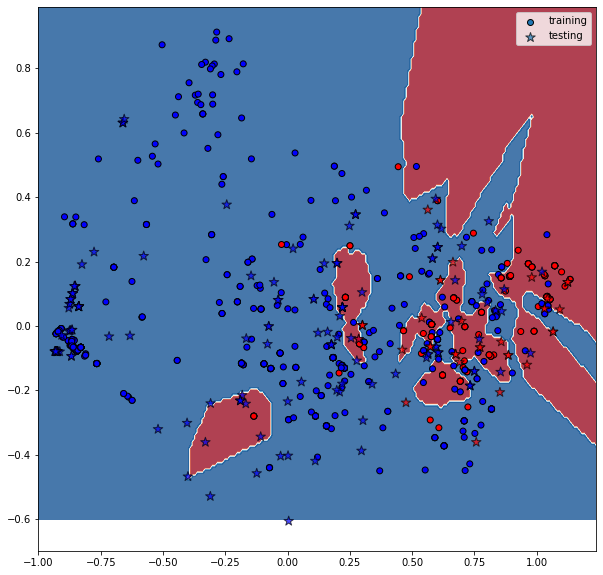

In [36]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap



cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
pca = PCA(n_components=2)
X_training_pca = pca.fit_transform(X_training)
X_testing_pca = pca.fit_transform (X_testing)

knn_=clone(grid_sgd_clf_acc.best_estimator_)
knn_clf.fit(X_training_pca,y_training)
array1,array2 = np.meshgrid(np.arange(-1,1.25, 0.01),np.arange(-0.6,1, 0.01))
Z = knn_clf.predict(np.c_[array1.ravel(),array2.ravel()])
Z = Z.reshape(array1.shape)


fig=plt.figure(figsize=(10,10))
plt.contourf(array1, array2, Z, cmap=cm, alpha=.8)
plt.scatter(x = X_training_pca[:,0], y = X_training_pca[:,1], c=y_training['correct_answ'],cmap=cm_bright,edgecolors='k',label='training')
plt.scatter(x = X_testing_pca[:,0],y = X_testing_pca[:,1], c=y_testing['correct_answ'], label='testing',marker='*',s=100,cmap=cm_bright, alpha=0.7,edgecolors='k')
plt.legend()

### 3.3.4 calculate the probability for all datapoints for UI
Because the best k=1, given one datapoint, it has only 100% of probability of being categorized to be either 0 or 1. Hence, the probability of each label is either 0 or 1

In [37]:
confidence_score = grid_knn_clf_acc.best_estimator_.predict_proba(X)
print(confidence_score[0:20,0:2])

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


## 3.4 random Forest
### 3.4.1 k_fold cross validation in training datasets to see performance

In [38]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score,confusion_matrix,f1_score
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier

# n_split = 3, in each training, 533 data points will be used for training
# and 266 data points will be used for testing

rf_clf = RandomForestClassifier()

skfolds = StratifiedKFold(n_splits=3, random_state=42)

recall=[]
precision=[]
f1=[]
for train_index, test_index in skfolds.split(X_training,y_training):
    clone_rf_clf = clone(rf_clf)
    X_train_folds = X_training.iloc[train_index]
    y_train_folds = y_training.iloc[train_index]
    X_test_folds = X_training.iloc[test_index]
    y_test_folds = y_training.iloc[test_index]
    clone_rf_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_rf_clf.predict(X_test_folds)
    print('confusion_matrix:')
    print(confusion_matrix(y_test_folds,y_pred))
    precision.append(precision_score(y_test_folds,y_pred))
    recall.append(recall_score(y_test_folds,y_pred))
    f1.append(f1_score(y_test_folds, y_pred))
print("mean f1:",np.mean(f1))
print("mean recall:",np.mean(recall))
print("mean precision:",np.mean(precision))
                    

/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


confusion_matrix:
[[ 53   5]
 [  6 203]]
confusion_matrix:
[[ 50   8]
 [ 16 193]]
confusion_matrix:
[[ 54   4]
 [  6 202]]
mean f1: 0.9636433094598905
mean recall: 0.9552968960863698
mean precision: 0.9722476892361692


/Users/chloekim12/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


### 3.3.2 use whole training datasets for trainig and validate performance in testing dataset

*n_estimators = number of trees in the foreset

*max_features = max number of features considered for splitting a node

*max_depth = max number of levels in each decision tree

*min_samples_split = min number of data points placed in a node before the node is split

*min_samples_leaf = min number of data points allowed in a leaf node

*bootstrap = method for sampling data points (with or without replacement)

In [39]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 20, num = 10)] # of trees in the forest
max_features = ['auto', 'sqrt','log2'] #number of features to consider when looking for the best split
max_depth = [1,2,3]  # maximum depth of the tree
max_depth.append(None)
min_samples_split = [1, 5] # min number of samples required to split an internal node
min_samples_leaf = [1, 2, 4] #min number of samples in a leaf node
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf_clf = RandomForestClassifier()
grid_rf_clf_acc = GridSearchCV(rf_clf, param_grid = random_grid,scoring = 'f1')
grid_rf_clf_acc.fit(X_training, y_training)

y_pred= grid_rf_clf_acc.predict(X_testing)

print('confusion_matrix: \n',confusion_matrix(y_testing,y_pred))
print('precision_score: ',precision_score(y_testing,y_pred))
print('recall_score: ',recall_score(y_testing,y_pred))
print('f1_socre: ',f1_score(y_testing,y_pred))
print('best_params_:',grid_rf_clf_acc.best_params_)

/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/chloekim12/anaconda3/lib/pyt

confusion_matrix: 
 [[ 32   4]
 [  8 156]]
precision_score:  0.975
recall_score:  0.9512195121951219
f1_socre:  0.9629629629629629
best_params_: {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 11}


/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/chloekim12/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [8]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(bootstrap=False, max_depth=None, max_features='log2', min_samples_leaf=1, min_samples_split=5, n_estimators=11)
X_training = data[['levenshtein','jaccard','cosine','elmo']]
y_training = data[['correct_answ']]
rf_clf.fit(X_training, y_training)
import pickle
pickle.dump(rf_clf, open('random_forest_confidence_score.sav', 'wb'))

c:\users\schaa\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


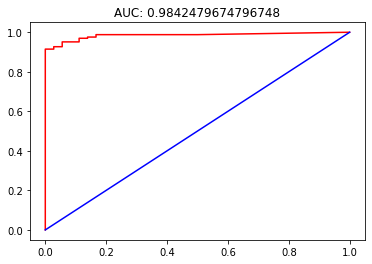

In [40]:
#AUC tells how much model is capable of distinguishing between classes (0,1)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(y_testing,y_pred):
    fpr, tpr, thresholds = roc_curve(y_testing, y_pred[:,1])
    plt.plot(fpr,tpr,'r')
    plt.plot([0,1],[0,1],'b')
    plt.title('AUC: {}'.format(auc(fpr,tpr)))
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()
    
plot_roc_auc(y_testing,grid_rf_clf_acc.predict_proba(X_testing))

### 3.4.3 PCA to reduce data dimension to visualize data

use pca to reduce the data dimension to 2-D, then train the 2 new attribute based on the best parameter we get from grid_search. 
As the testing datapoints are predicted based on 5 attribute, and the background point of the figure is predicted based on 2 features, there are some red stars in blue background, vice versa. 

/Users/chloekim12/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


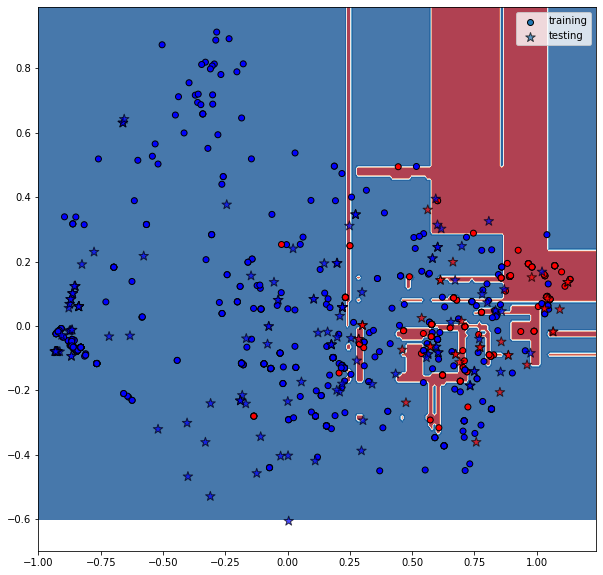

In [41]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap



cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
pca = PCA(n_components=2)
X_training_pca = pca.fit_transform(X_training)
X_testing_pca = pca.fit_transform (X_testing)

rf_clf=clone(grid_rf_clf_acc.best_estimator_)
rf_clf.fit(X_training_pca,y_training)
array1,array2 = np.meshgrid(np.arange(-1,1.25, 0.01),np.arange(-0.6,1, 0.01))
Z = rf_clf.predict(np.c_[array1.ravel(),array2.ravel()])
Z = Z.reshape(array1.shape)


fig=plt.figure(figsize=(10,10))
plt.contourf(array1, array2, Z, cmap=cm, alpha=.8)
plt.scatter(x = X_training_pca[:,0], y = X_training_pca[:,1], c=y_training['correct_answ'],cmap=cm_bright,edgecolors='k',label='training')
plt.scatter(x = X_testing_pca[:,0],y = X_testing_pca[:,1], c=y_testing['correct_answ'], label='testing',marker='*',s=100,cmap=cm_bright, alpha=0.7,edgecolors='k')
plt.legend()

### 3.3.4 calculate the probability for all datapoints for UI

In [42]:
confidence_score = grid_rf_clf_acc.best_estimator_.predict_proba(X)
print(confidence_score[0:30])

[[0.         1.        ]
 [0.68181818 0.31818182]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.06818182 0.93181818]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.42424242 0.57575758]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.18181818 0.81818182]
 [0.         1.        ]
 [0.63636364 0.36363636]
 [0.         1.        ]
 [0.27272727 0.72727273]
 [0.         1.        ]
 [0.03030303 0.96969697]
 [0.06060606 0.93939394]
 [0.         1.        ]
 [0.         1.        ]
 [0.42424242 0.57575758]
 [0.02272727 0.97727273]]


# 4 Summary
## 4.1 Logistic Regression 

(1)
Using the training datasets for cross validation without optimizing hyperparameters, we get the mean performance:
<br>mean f1: 0.9131051942879901
<br>mean recall: 0.942857142857143
<br>mean precision: 0.885186793936794

(2) 
Using the whole training datasets for training, with optimization for hyperparameters, we get the following performance on testing datasets:

confusion_matrix: 

 [[ 26  14]<br>
 [  9 151]]
 
f1_socre:  0.9292307692307692
<br>recall_score:  0.94375

<br>precision_score:  0.9151515151515152

<br>best_params_: {'C': 50, 'class_weight': 'None', 'penalty': 'l2'}

(3)data visualization

![Logistic Regression](./img/lr.png)

## 4.2 SGD  Classifier 

(1)Using the training datasets for cross validation without optimizing hyperparameters, we get the mean performance:
<br>mean f1: 0.8969852159157746
<br>mean recall: 0.8746031746031746
<br>mean precision: 0.9295187421244365

(2) 
Using the whole training datasets for training, with optimization for hyperparameters, we get the following performance on testing datasets:

confusion_matrix: <br>
 [[ 26  14]<br>
 [  9 151]]
 
precision_score:  0.9151515151515152
<br>recall_score:  0.94375
<br>f1_socre:  0.9292307692307692
<br>best_params_: {'C': 50, 'class_weight': 'None', 'penalty': 'l2'}

(3)data visualization
![SGD Classifier](./img/sgd.png)

## 4.3 KNN  Classifier 

(1)Using the training datasets for cross validation without optimizing hyperparameters, we get the mean performance:
<br>mean f1: 0.9352627531168615
<br>mean recall: 0.9317460317460317
<br>mean precision: 0.9396529444205415

(2) 
Using the whole training datasets for training, with optimization for hyperparameters, we get the following performance on testing datasets:

confusion_matrix: <br>
 [[ 35   5]<br>
 [  7 153]]
 
precision_score:  0.9683544303797469
<br>recall_score:  0.95625
<br>f1_socre:  0.9622641509433963
<br>best_params_: {'n_neighbors': 1, 'p': 1}

(3)data visualization
![KNN Classifier](./img/knn.png)

## 4.4 Random Forest  Classifier 

(1)Using the training datasets for cross validation without optimizing hyperparameters, we get the mean performance:
<br>mean f1: 0.9680531918661637
<br>mean recall: 0.9634920634920635
<br>mean precision: 0.9730844569423415

(2) 
Using the whole training datasets for training, with optimization for hyperparameters, we get the following performance on testing datasets:

confusion_matrix: <br>
 [[ 34   6]<br>
 [  3 157]]
 
precision_score:  0.9631901840490797
<br>recall_score:  0.98125
<br>f1_socre:  0.9721362229102166
<br>best_params_: {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 11}

(3)data visualization
![Random Forest Classifier](./img/rf.png)
